In [1]:
import torchvision
import torch
from torchvision import transforms
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import DataLoader
from torch import nn,optim
import numpy as np
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Data Processing and Augementation
transformation = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.3),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Separate transform for test data (no augmentation)
test_transformation = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [2]:
# spliting the data into train and test
train_data = torchvision.datasets.ImageFolder(root = r"C:\Users\vmami\guvi_DS\Data\fer2013\train",transform=transformation)
test_data = torchvision.datasets.ImageFolder(root = r"C:\Users\vmami\guvi_DS\Data\fer2013\test",transform=test_transformation)

# Calculate class weights for weighted loss function
class_counts = torch.zeros(7)
for _, labels in train_data:
    class_counts[labels] += 1

# Compute inverse frequency weights
class_weights = 1.0 / (class_counts + 1e-8)
# Normalize weights so they sum to number of classes
class_weights = class_weights * (7 / class_weights.sum())

# Create balanced sampling strategy for training
class_indices = {i: [] for i in range(7)}
for idx, (_, label) in enumerate(train_data):
    class_indices[label].append(idx)

# Use more samples from underrepresented classes
balanced_indices = []
max_samples_per_class = max([len(indices) for indices in class_indices.values()])

for i in range(7):
    if len(class_indices[i]) > 0:
        # Oversample minority classes
        samples = np.random.choice(
            class_indices[i], 
            size=max_samples_per_class, 
            replace=(len(class_indices[i]) < max_samples_per_class)
        )
        balanced_indices.extend(samples)

train_sampler = SubsetRandomSampler(balanced_indices)

# Similar approach for test data
test_class_indices = {i: [] for i in range(7)}
for idx, (_, label) in enumerate(test_data):
    test_class_indices[label].append(idx)

test_balanced_indices = []
min_test_samples = min([len(indices) for indices in test_class_indices.values() if len(indices) > 0])
samples_per_class = max(min_test_samples, 111)  # Ensure minimum samples per class

for i in range(7):
    if len(test_class_indices[i]) > 0:
        samples = np.random.choice(
            test_class_indices[i],
            size=min(samples_per_class, len(test_class_indices[i])),
            replace=False
        )
        test_balanced_indices.extend(samples)

test_sampler = SubsetRandomSampler(test_balanced_indices)


# giving the splited data to data loaders
train_loader = DataLoader(
    train_data, 
    batch_size=64,  
    sampler=train_sampler,
    num_workers=4,  
    pin_memory=True
)
test_loader = DataLoader(
    test_data,
    batch_size=64,
    sampler=test_sampler,
    num_workers=4,
    pin_memory=True
)

# creating cnn model 
class CNN_FER(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(CNN_FER, self).__init__()
        
        # Feature extraction blocks with residual connections
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(dropout_rate)
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(dropout_rate)
        )
        
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(dropout_rate)
        )
        
        # Additional layer for more capacity
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(dropout_rate)
        )
        
        # Global average pooling to reduce parameters
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 7)
        )
        
    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        
        # Global average pooling
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_FER(dropout_rate=0.4).to(device)


criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.AdamW(
    model.parameters(),
    lr=0.0005,  # Lower learning rate for better convergence
    weight_decay=0.01,  # L2 regularization
    betas=(0.9, 0.999)
)
def get_lr_scheduler(optimizer, num_epochs):
    # Linear warmup for 5% of training
    warmup_epochs = int(0.05 * num_epochs)
    
    def lr_lambda(epoch):
        # Warm-up phase
        if epoch < warmup_epochs:
            return epoch / warmup_epochs
        # Cosine annealing phase
        else:
            return 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (num_epochs - warmup_epochs)))
    
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

num_epochs = 50
scheduler = get_lr_scheduler(optimizer, num_epochs)
# For tracking metrics
train_losses = []
test_accuracies = []
best_accuracy = 0.0
patience = 5  # For early stopping
epochs_no_improve = 0
def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# Mixup loss calculation
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

for epoch in range(1, num_epochs + 1):
    # Training phase
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Apply mixup data augmentation with 50% probability
        if np.random.random() > 0.5:
            inputs, targets_a, targets_b, lam = mixup_data(inputs, labels)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        else:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
        
        # Calculate training accuracy
        _, predictions = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predictions == labels).sum().item()
    
    train_acc = 100 * correct / total
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Evaluation phase
    model.eval()
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            
            test_total += labels.size(0)
            test_correct += (predictions == labels).sum().item()
            
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * test_correct / test_total
    test_accuracies.append(accuracy)
    
    # Calculate additional metrics
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    
    # Print training statistics
    print(f"Epoch {epoch}/{num_epochs}:")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}\n")
    
    # Learning rate scheduling
    scheduler.step()
    
    # Save best model and implement early stopping
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }, 'best_emotion_model.pth')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch} epochs!")
            break

Epoch 1/50:
Train Loss: 2.0340, Train Acc: 14.43%
Test Accuracy: 14.29%
Precision: 0.0204
Recall: 0.1429
F1-Score: 0.0357
Learning Rate: 0.000000

Epoch 2/50:
Train Loss: 1.3701, Train Acc: 14.31%
Test Accuracy: 14.29%
Precision: 0.0204
Recall: 0.1429
F1-Score: 0.0357
Learning Rate: 0.000250

Epoch 3/50:
Train Loss: 1.2666, Train Acc: 15.50%
Test Accuracy: 20.33%
Precision: 0.1193
Recall: 0.2033
F1-Score: 0.1147
Learning Rate: 0.000500

Epoch 4/50:
Train Loss: 1.1059, Train Acc: 20.87%
Test Accuracy: 26.38%
Precision: 0.1366
Recall: 0.2638
F1-Score: 0.1529
Learning Rate: 0.000499

Epoch 5/50:
Train Loss: 1.0035, Train Acc: 26.29%
Test Accuracy: 37.84%
Precision: 0.3795
Recall: 0.3784
F1-Score: 0.3062
Learning Rate: 0.000498

Epoch 6/50:
Train Loss: 0.9466, Train Acc: 30.95%
Test Accuracy: 44.66%
Precision: 0.4173
Recall: 0.4466
F1-Score: 0.3781
Learning Rate: 0.000495

Epoch 7/50:
Train Loss: 0.8988, Train Acc: 33.28%
Test Accuracy: 48.52%
Precision: 0.4028
Recall: 0.4852
F1-Score: 0.4

In [3]:
torch.save(model.state_dict(), r"..\Data\CNN_FER2013.pth")

In [4]:
torch.load("model.pth", weights_only=True)

OrderedDict([('convolution.0.weight',
              tensor([[[[ 0.3485, -0.4186, -0.3246],
                        [ 0.4124,  0.3350, -0.3190],
                        [ 0.4985,  0.5329, -0.4567]],
              
                       [[ 0.2608, -0.4122, -0.3558],
                        [ 0.5528,  0.3704, -0.4173],
                        [ 0.5819,  0.3946, -0.1589]],
              
                       [[ 0.5749, -0.3218, -0.5125],
                        [ 0.3559,  0.2670, -0.3794],
                        [ 0.3455,  0.3577, -0.4031]]],
              
              
                      [[[ 0.6090,  0.3724,  0.5100],
                        [ 0.3632,  0.5631,  0.2883],
                        [ 0.5708,  0.5254,  0.3305]],
              
                       [[ 0.4311,  0.3363,  0.2898],
                        [ 0.3399,  0.5178,  0.3326],
                        [ 0.6065,  0.3410,  0.3362]],
              
                       [[ 0.3911,  0.4725,  0.2814],
                  

In [5]:
import torchvision.models as models

# Using pre-trained models
model = models.resnet50(pretrained=True)
for parameter in model.parameters():
    parameter.required_grad=False
model.fc = nn.Linear(model.fc.in_features,100)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
num_epoch = 10
for epoch in range (1,num_epoch+1):
    optimizer.zero_grad()
    total_loss = 0
    for input,labels in train_loader:
        output = model(input)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        total_loss = total_loss+loss.item()
    print(f"{epoch}/{num_epoch}: loss: {total_loss}")
    with torch.no_grad():
        total_loss = 0
        for imgs,labels in train_loader:
            output = model(imgs)
            loss = criterion(output,labels)
            total_loss = total_loss+loss.item()
        print(f"Train_set total_loss: {total_loss}")

C:\Users\vmami\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\vmami\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


1/10: loss: 361.71563589572906
Train_set total_loss: 375.0783181190491
2/10: loss: 297.5626024007797
Train_set total_loss: 276.5073026418686
3/10: loss: 243.42717278003693
Train_set total_loss: 234.81884002685547
4/10: loss: 230.98191249370575
Train_set total_loss: 216.45651984214783
5/10: loss: 204.5808812379837
Train_set total_loss: 209.30655670166016
6/10: loss: 199.57645845413208
Train_set total_loss: 195.2507872581482
7/10: loss: 194.4286437034607
Train_set total_loss: 203.4444236755371
8/10: loss: 202.65502905845642
Train_set total_loss: 195.70259928703308
9/10: loss: 193.62744414806366
Train_set total_loss: 202.13181006908417
10/10: loss: 196.58480072021484
Train_set total_loss: 204.6664593219757


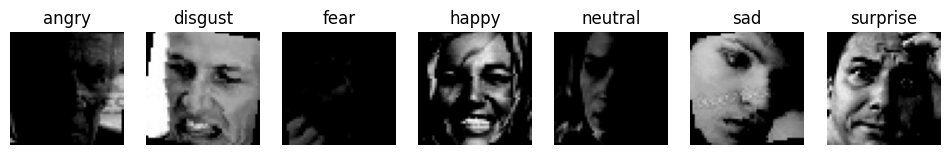

In [22]:
import matplotlib.pyplot as plt
import numpy as np

train_data = torchvision.datasets.ImageFolder(root = r"C:\Users\vmami\guvi_DS\Data\fer2013\train",transform=transformation)
test_data = torchvision.datasets.ImageFolder(root = r"C:\Users\vmami\guvi_DS\Data\fer2013\test",transform=transformation)

# giving the splited data to data loaders
train_loader = DataLoader(train_data,batch_size=64,shuffle=True)
test_loader = DataLoader(test_data,batch_size=64,shuffle=True)

# Get one batch of images and labels
class_names = train_data.classes
class_images = {class_name: None for class_name in class_names}

for img, label in train_loader:
    for i in range(len(img)):
        class_name = class_names[label[i].item()]
        if class_images[class_name] is None:
            class_images[class_name] = img[i]
            # Once you have one image from each class, you can break the loop
            if None not in class_images.values():
                break
    if None not in class_images.values():
        break

# Function to show the selected images from each class
def show_images_from_classes(class_images, num_classes=7):
    fig, axes = plt.subplots(1, num_classes, figsize=(12, 4))
    class_names = list(class_images.keys())[:num_classes]  # Get the first 'num_classes' class names

    for i in range(num_classes):
        img = class_images[class_names[i]].numpy().transpose((1, 2, 0))  # Convert (C, H, W) → (H, W, C)
        img = np.clip(img, 0, 1)  # Ensure pixel values are between 0 and 1
        axes[i].imshow(img)
        axes[i].set_title(f"{class_names[i]}")
        axes[i].axis("off")

    plt.show()

# Display the first 7 images, one from each class
show_images_from_classes(class_images, num_classes=7)

In [5]:
# calculating metrics for the models
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
predictions = []
true_labels = []
with torch.no_grad():
        for input,labels in test_loader:
            output = model(input)
            _,prediction = torch.max(output,1)
            predictions.extend(prediction.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average = 'weighted', zero_division=0)
f1 = f1_score(true_labels, predictions, average = 'weighted', zero_division=0)
recall = recall_score(true_labels, predictions, average = 'weighted', zero_division=0)
print(f"accuracy_score: {accuracy:.2f}")
print(f"precision_score: {precision:.2f}")
print(f"f1_score: {f1:.2f}")
print(f"recall_score: {recall:.2f}")

accuracy_score: 0.64
precision_score: 0.65
f1_score: 0.64
recall_score: 0.64


In [6]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
predictions = []
true_labels = []
with torch.no_grad():
        for input,labels in train_loader:
            output = model(input)
            _,prediction = torch.max(output,1)
            predictions.extend(prediction.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average = 'weighted', zero_division=0)
f1 = f1_score(true_labels, predictions, average = 'weighted', zero_division=0)
recall = recall_score(true_labels, predictions, average = 'weighted', zero_division=0)
print(f"accuracy_score: {accuracy:.2f}")
print(f"precision_score: {precision:.2f}")
print(f"f1_score: {f1:.2f}")
print(f"recall_score: {recall:.2f}")

accuracy_score: 0.72
precision_score: 0.72
f1_score: 0.72
recall_score: 0.72


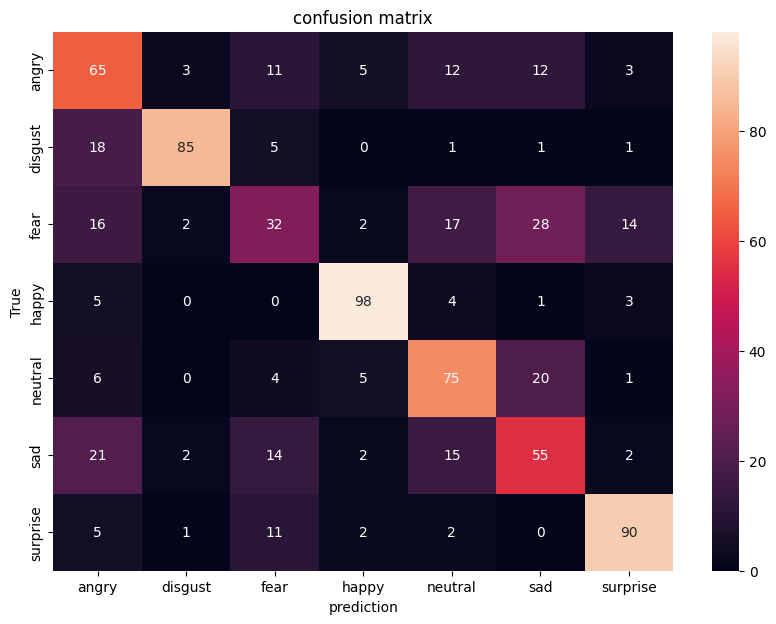

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot = True, fmt="d", xticklabels= train_data.classes, yticklabels=test_data.classes)
plt.xlabel('prediction')
plt.ylabel('True')
plt.title("confusion matrix")
plt.show()